In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm
from numpy.linalg import inv # used to calculate the inverse of (X'X)
import copy
from scipy.stats import t
from scipy.stats import f
from statsmodels.formula.api import ols

![image.png](raw/dfExplained.png)

In [12]:
df = pd.read_csv('raw/CarMileageTest.csv')
df.tail()

,mfr,carline,car/truck,cid,rhp,trns,drv,od,etw,cmp,axle,n/v,a/c,hc,co,co2,mpg
16,20,SEBRING 4-DR,C,165,200,L4,F,2,3625,9.7,2.69,36.8,Y,0.011,0.12,252,35.1
17,20,STRATUS 4-DR,C,148,167,L4,F,2,3500,9.5,2.69,36.8,Y,0.002,0.06,233,37.9
18,20,TOWN & COUNTRY 2WD,T,148,150,L4,F,2,4250,9.4,2.69,34.9,Y,0.000,0.09,262,33.8
19,20,VIPER CONVERTIBLE,C,500,501,M6,R,2,3750,9.6,3.07,19.4,Y,0.007,0.05,342,25.9
20,20,WRANGLER/TJ 4WD,T,148,150,M6,4,2,3625,9.5,3.73,40.1,Y,0.004,0.43,337,26.4


<hr style="border-top: 0.5px solid #b;">
<b style="font-size: 22px;">Task1</b> <h style="font-size: 18px;"> : Fit a multiple linear regression model to these data to estimate gasoline mileage that uses the following independent variables: cid, rhp, etw, cmp, axle, n/v. </h>
<hr style="border-top: 0.5px solid #b;">

In [13]:
cols_x = ['cid', 'rhp', 'etw', 'cmp', 'axle', 'n/v']
X = df[cols_x] 
y = df['mpg']

X_ols = sm.add_constant(X)
model = sm.OLS(y,X_ols)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     19.53
Date:                Wed, 13 Mar 2024   Prob (F-statistic):           4.66e-06
Time:                        17:06:38   Log-Likelihood:                -42.366
No. Observations:                  21   AIC:                             98.73
Df Residuals:                      14   BIC:                             106.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.9040     19.665      2.538      0.0

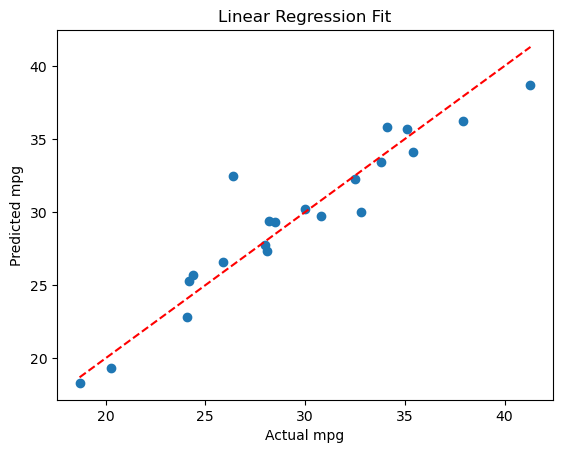

In [14]:
# Generate predicted values using the fitted model
y_pred = result.predict(X_ols)

# Plot the regression fit
plt.scatter(y, y_pred)
# diagonal line which represents predicted mpg would be exactly equal to the actual mpg
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  
plt.xlabel('Actual mpg')
plt.ylabel('Predicted mpg')
plt.title('Linear Regression Fit')
plt.show()

<hr style="border-top: 0.5px solid #b;">
<b style="font-size: 22px;">Task2</b> <h style="font-size: 18px;">  : Estimate σ2(variance) and the standard errors of the regression coefficients without using statsmodels.api module. </h>
<hr style="border-top: 0.5px solid #b;">

Standard errors of the regression coefficients: <br>
\begin{equation}
    se(\hat{\beta}_i) = \hat{\sigma}^2 C_{ii}
\end{equation}

where σ2(variance) is calculated as: <br>
$$
\hat{\sigma}^2 = \frac{SSE}{n-p}
$$
<br>

where Cii is calculated as: <br>
\begin{equation}
    C = (X^{\prime}X)^{-1}
\end{equation}

##### 1) Calculate Variance

In [15]:
n = len(X)                                                            # the total number of observations
k = X.shape[1]                                                        # the total number of independent variables
p = k + 1                                                             # the total number of parameters (including the intercept term which is denoted as + 1)

residuals = y_pred - y                                                # SSE = sum of the residuals  
hat_sigma = np.sqrt((residuals**2).sum()/(n-p))                       # the unbiased estimator of noise variance
variance = hat_sigma**2                                               # variance

print("Estimated σ²:", variance)                                      # the ANSWER

Estimated σ²: 4.965298889568137


##### 2) Calculate C

In [16]:
X_c = copy.deepcopy(X)                                                # create copy of X to amend the variable
X_c.insert(loc=0, column='constant', value=1)                         # add a column with all 1 to account for the intercept term in the model.
C = inv(np.dot(X_c.T, X_c))                                           # '.T' provides the transpose of the matrix

##### 3) Calculate SE

In [17]:
SE = []                                                               # initialize the list object
for i in range(p):
    se_beta = np.sqrt((hat_sigma**2)*C[i,i])                          # calculate the standard error of coef
    SE.append(se_beta.round(3))                                       # add se to the list

print("Standard errors of coefficients:")                             # the ANSWER
print(SE)

Standard errors of coefficients:
[19.665, 0.023, 0.016, 0.001, 1.765, 1.329, 0.273]


<hr style="border-top: 0.5px solid #b;">
<b style="font-size: 22px;">Task3</b> <h style="font-size: 18px;">  : Test for significance of regression using significance level α = 0.05 without using statsmodels.api module. </h>
<hr style="border-top: 0.5px solid #b;">

Assessing the significance of the linear regression requires F-value: <br>
<br>
F-value = MSR / MSE <br>
- MSR = mean square for the regression Sum of Square(SSR) <br>
- MSE = the Residual Sum of Squares(SSE) <br>


MSR = SSR / k (degree_of_freedom(df) based on the ttl # of independent variables) <br>
MSE = SSE / (n - (k + 1)) (df based on the ttl # of obs)<br>
SSR = SUM(y_predict - y_mean)^2 <br>
SSE = SUM(y_predict - y_actual)^2 <br>

<br>
The null(H0) and alternative(H1) hypothesis of this F-test is as follows: <br>
- H0: The regression model is not significant (all coefficients are zero). <br>
- H1: The regression model is significant (at least one coefficient is non-zero). <br>


In [18]:
SSR = ((y_pred - y.mean())**2).sum()                                  # Regression sum of squares
SSE = (residuals**2).sum()                                            # Error sum of squares
MSR = SSR / k                                                         # Mean regression sum of squares
MSE = SSE / (n - p)                                                   # Mean error sum of squares
F = MSR / MSE                                                         # F-statistic
p_value = f.sf(F, k, n - p)                                           # p-value

alpha = 0.05                                                          # the ANSWER
print("p-value of the F-test is:", p_value)

if (p_value < alpha):
    print("The model is significant (at least one coefficient is non-zero)")
else:
    print("The model is not significant (all coefficients are zero)")

p-value of the F-test is: 4.663951412790637e-06
The model is significant (at least one coefficient is non-zero)


<hr style="border-top: 0.5px solid #b;">
<b style="font-size: 22px;">Task4</b> <h style="font-size: 18px;">  : Find the t-test statistic for each independent variable statsmodels.api module. Using α = 0.05, what conclusions can you draw? Does each independent variable contribute to the model? </h>
<hr style="border-top: 0.5px solid #b;">

In [19]:
critical_value = t.ppf(1 - alpha/2, n - p)                      # calculate critical value
reg = linear_model.LinearRegression()                                 
reg.fit(X, y);                                                        # train linear regression NOT using statsmodels.api
t_test_statistics = np.abs(reg.coef_ / np.array(SE[1:]))              # Exclude the intercept term, SE = the standard error of the coefficient

for i in range(k):                                                    # the ANSWER, looping over the number of independant variables
    if t_test_statistics[i] > critical_value:
        print(f"The t-value of '{cols_x[i]}' is '{round(t_test_statistics[i],3)}' which is larger than critical_value,'{round(critical_value,3)}'. Thus, it has a significant impact on the dependent variable.")

The t-value of 'etw' is '3.236' which is larger than critical_value,'2.145'. Thus, it has a significant impact on the dependent variable.
The t-value of 'axle' is '2.901' which is larger than critical_value,'2.145'. Thus, it has a significant impact on the dependent variable.


Given the result, 'etw' and 'axle' contribute to the model and the rest of the independent variables do not have significant impacts on the dependent variable.

<hr style="border-top: 0.5px solid #b;">
<b style="font-size: 22px;">Task5</b> <h style="font-size: 18px;">  : Find 99% confidence intervals on the regression coefficients. </h>
<hr style="border-top: 0.5px solid #b;">

In [20]:
CI_alpha = 0.01                                                       # significance level (1 - confidence level)
t_value = t.ppf(1 - CI_alpha / 2, df = n - p)                         # Calculate the t-value for a two-tailed test with alpha/2 significance level
SE_coef = SE[1:]                                                      # exclude SE of an intercept

confidence_intervals = []                                             # initiate the list object for CI
for i in range(k):                                                    # loop over the parameters
    lower_CI = reg.coef_[i] - t_value * SE_coef[i]                    # SE = the standard error of the coefficient
    upper_CI = reg.coef_[i] + t_value * SE_coef[i]
    confidence_intervals.append((lower_CI, upper_CI))                 # add lower_CI and upper_CI for each of the coef incl. intercept

for i, col in enumerate(cols_x):                                      # the ANSWER, loop over cols_x and extract both i and each col
    print(f"Confidence interval for {col}: {confidence_intervals[i]}")

Confidence interval for cid: (-0.07891480143600191, 0.05801996433318046)
Confidence interval for rhp: (-0.04883372349908406, 0.046425243992521056)
Confidence interval for etw: (-0.006213243860924651, -0.0002595583926993314)
Confidence interval for cmp: (-4.9616997269735, 5.546555124444189)
Confidence interval for axle: (-7.811588603766899, 0.10085938350455059)
Confidence interval for n/v: (-0.6229686959097731, 1.0023874369157393)


<hr style="border-top: 0.5px solid #b;">
<b style="font-size: 22px;">Task6</b> <h style="font-size: 18px;">  : Plot residuals versus y_hat and versus each independent variable. Discuss these residual plots. </h>
<hr style="border-top: 0.5px solid #b;">

##### 1) residual vs y_hat

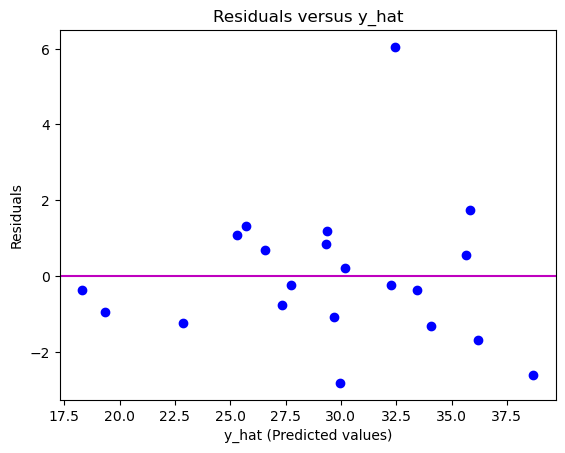

In [21]:
plt.scatter(y_pred, residuals, c = 'b')
plt.axhline(0, c = 'm')
plt.xlabel('y_hat (Predicted values)')
plt.ylabel('Residuals')
plt.title('Residuals versus y_hat')
plt.show()

##### 2) Residuals vs each independent variable

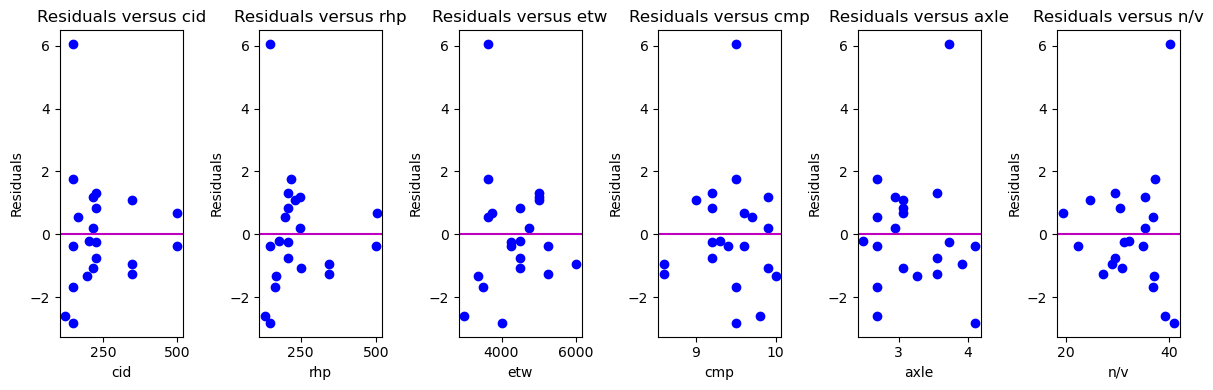

In [22]:
fig, ax = plt.subplots(1, 6, figsize=(12, 4))

for i, col in enumerate(cols_x):
    ax[i].scatter(X[col], residuals, c='b')
    ax[i].axhline(0, c='m')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Residuals')
    ax[i].set_title(f'Residuals versus {col}')

plt.tight_layout()
plt.show()

In [23]:
print(f"the largest residual, or the outlier is '{residuals.max()}' which is {residuals.idxmax() + 1}th sample in the data") 

the largest residual, or the outlier is '6.05009069372128' which is 21th sample in the data


The scatter of residuals around the zero line across each variable has been assessed. <br>Generally, y_hat, cid, rhp, etw, cmp, axle, and n/v appear to conform to expectations. <br>Nevertheless, an outlier in the residuals of the final sample indicates a deviation from the model's predictions, suggesting the need for closer inspection and potential corrective measures to enhance model accuracy.

<hr style="border-top: 0.5px solid #b;">
<b style="font-size: 22px;">Task7</b> <h style="font-size: 18px;">  : Using α = 0.05, plot the confidence limits and prediction limits for the mean response. </h>
<hr style="border-top: 0.5px solid #b;">

In [24]:
df_c = copy.deepcopy(df)                                              # copy the original dataset to change the column name while maintaining the original
df_c.rename(columns={'n/v': 'nv'}, inplace = True)                    # change the column name given '/' symbol causes error when fitting OLS model             

formula = 'mpg ~ cid + rhp + etw + cmp + axle + nv'                   # define the independent and dependent variables
model = ols(formula=formula, data = df_c).fit()                       # fit the linear regression model using OLS package to get the detailed prediction

alpha = 0.05                                                          # safe assign 0.05 to alpha
predictions = model.get_prediction(df_c).summary_frame(alpha)         # get the predictions with mean and CI
predictions.head(3)


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,29.710411,1.395095,26.718230,32.702593,24.071788,35.349034
1,32.270833,1.091272,29.930287,34.611378,26.949266,37.592400
2,34.086592,1.322638,31.249815,36.923369,28.528875,39.644310


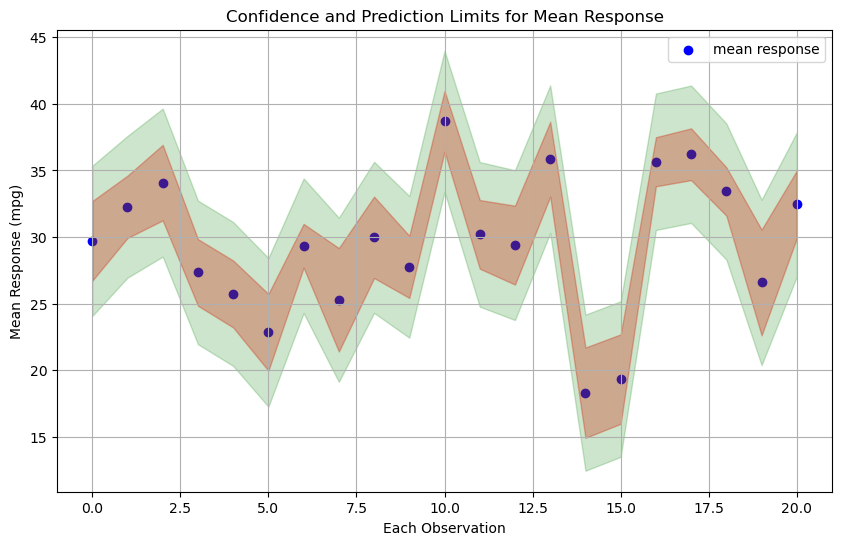

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(df_c.index, predictions['mean'],                          # x-axis and y-axis
            color='blue', 
            label='mean response')
plt.fill_between(df_c.index,                                          # fill each obs
                 predictions['mean_ci_lower'],                        # lower bound
                 predictions['mean_ci_upper'],                        # upper bound
                 color='red', alpha=0.3)
plt.fill_between(df_c.index, 
                 predictions['obs_ci_lower'], 
                 predictions['obs_ci_upper'], 
                 color='green', alpha=0.2)
plt.xlabel('Each Observation')
plt.ylabel('Mean Response (mpg)')
plt.title('Confidence and Prediction Limits for Mean Response')
plt.legend()
plt.grid(True)
plt.show()